# COGS 108 - Final Project 

# Overview

This project specifically analysis the relationship between yelp rating and health inspection score with calculating p-value. It proves that the health inspection score is hight if the yelp rating is high. 

# Name & PID

- Name: Youngwoo Park
- PID: A14758820

# Research Question

Is there any relationship between health inspection grades and yelp rating?

## Background and Prior Work

Yelp which is the biggest review site uploads health score in their site, so over than 350,000 restaurants in the U.S. should display their score in the page. However, in the U.S, there are more than 660,000 restaurant, so users could not know the health inspection score in yelp. 

Many people upload their feedback of the restaurant in the app, so if I found the relationship between the yelp rating and food safety, officers of city gorenment can prioritize of the restaurants where they do not visit yet.

Most of people easily can think high rating restaraunts are popular, so it should be cleaner than lower restaruants. However, Restauarantware, which is the food service supply company, revealed some 5-star restaurants, such as Italian, steakhouse, and sushi restaurants, are dirtier than fast food restaurants,including KFC, Chick-fil-A, and McDonalds', so it is possible that low-rating restaurants have high health inspect grade.

References (include links):

-1) https://www.reviewtrackers.com/blog/yelp-health-score/

-2)https://www.thedailymeal.com/healthy-eating/fast-food-cleaner-five-star-restaurants-study/020718-0

-3)https://www.cdc.gov/publichealthgateway/accreditation/index.html

# Hypothesis


My hypothesis is high-rating restaurants get higher food safety grade than low-rating restaurants because many people make much of cleaness when they rate the restaurants.

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name: yelp.csv
- Link to the dataset: professor given
- Number of observations: 3688

- Dataset Name: inspections.csv
- Link to the dataset: professor given
- Number of observations:18466

I need to use rating and the restauarnts' names from yelp.csv and inspection grade from insspections.csv. There are same restaurants from both datas, so I just use those common restaurants.

# Setup

In [30]:
## YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

Describe your data cleaning steps here.

### Load the data

In [2]:
## YOUR CODE HERE
inspection_df = pd.read_csv("inspections.csv")
yelp_df = pd.read_csv("yelp.csv")

### Delete Useless data

This program does not use some datas such as hsisid, day from the open day, and description, so delete those columns to make analysis easiler.

In [3]:
inspection_df = inspection_df.drop(inspection_df.columns[[0, 1, 3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35]], axis=1)
yelp_df = yelp_df.drop(yelp_df.columns[[0,2,4,5,6,7,8,9]], axis=1)
yelp_df = yelp_df.drop(yelp_df.columns[3:],axis=1)

In [4]:
yelp_df = yelp_df[['name','phone','rating']]

Since the inspector never visits, we cannot analysis, so delete the rows if the number of inspection is 0.

In [5]:
inspection_df = inspection_df.drop(inspection_df[inspection_df.inspection_num==0].index)

There are duplicate stores, so this program need to combine same name restaurants.

1. this program needs to standardize their names with lower cases and non-whitespace.

Before standardizing the names, we have

In [6]:
print(inspection_df['name'].unique().shape,yelp_df['name'].unique().shape)

(2908,) (2619,)


In [7]:
def standardize_name(str_in):
    # Make the input all lowercase
    str_in = str_in.lower()
    
    # Drop all whitespace
    str_in = str_in.strip()
    
    return str_in

In [8]:
inspection_df['name'] = inspection_df['name'].apply(standardize_name)
yelp_df['name'] = yelp_df['name'].apply(standardize_name)

After standardizing the names:

In [9]:
print(inspection_df['name'].unique().shape,yelp_df['name'].unique().shape)

(2871,) (2619,)


In [10]:
inspection_df

,name,phonenumber,inspection_num,score
0,cafe 3000 at wake med,(919) 350-8047,1,96.0
1,overtime sports pub,(919) 255-9556,1,98.0
2,taste of china,(919) 773-2285,1,97.0
3,panera bread #1643,NaN,1,99.0
4,walmart supercenter #4499-00 deli/bakery,(919) 269-2221 ext. 304,1,97.0
...,...,...,...,...
18461,sino wok,(919) 792-2499,10,93.0
18462,weatherstone elem. sch. cafeteria,(919) 380-6985,9,97.0
18463,alston ridge elementary school cafeteria,NaN,9,96.0
18464,food lion #996 meat market,(919) 772-0317,10,99.0


Combine duplicate restaurants which have same name from inspection data, and combine the common restaurants which has yelp rating.

It could be possible that there duplicates restaurants in yelp data, so I add all ratings with same name and divides by the number of same name restaurants.

In [12]:
uniqueName_ins = inspection_df['name'].value_counts().keys().tolist()
count = 0
data = []
#new_inspection_df = pd.DataFrame(new_data)

for namae in uniqueName_ins:
    sumDup = inspection_df['name'].value_counts()[namae]
    sumC = 0
    rate = 0
    count_in = 0
    num_of_Inspect = 0
    score = 0
    if sumDup > 1:
        for i in range(len(inspection_df['name'])):
            if inspection_df['name'][i] == namae:
                score += inspection_df['score'][i]
                sumC += 1
                if sumC == sumDup:
                    break
    else:
        for j in range(len(inspection_df['name'])):
            if inspection_df['name'][j] == namae:
                score = inspection_df['score'][j]
                break    
    for k in range(len(yelp_df['name'])):
        if yelp_df['name'][k] == namae:
            rate += yelp_df['rating'][k]
            count_in += 1
    if count_in == 0:
        #print(namae)
        continue
    rate /= count_in
    score /= sumDup
    data.append([namae,score,rate])
    #print(count ,"(",namae,")",rate, "/ ", count_in, " score: ", score)
    count+=1
    
new_inspection_df = pd.DataFrame(data,columns=['name','score','rating'])
print(new_inspection_df)

0 ( subway ) 2.80327868852459 /  61  score:  96.61818181818182
moe`s southwest grill
1 ( los tres magueyes ) 3.5 /  9  score:  93.79591836734694
wang`s kitchen
2 ( taco bell ) 2.5714285714285716 /  14  score:  96.31395348837209
greek fiesta
3 ( bojangles ) 3.2058823529411766 /  17  score:  96.125
4 ( carolina ale house ) 3.0 /  6  score:  95.04285714285714
applebee`s
5 ( chick-fil-a ) 3.9444444444444446 /  27  score:  96.04545454545455
6 ( taste of china ) 3.625 /  4  score:  95.41666666666667
7 ( la rancherita ) 3.6666666666666665 /  3  score:  96.03448275862068
8 ( jumbo china ) 3.25 /  4  score:  94.5576923076923
9 ( starbucks ) 3.2195121951219514 /  41  score:  96.92307692307692
goodberry`s creamery
papa john`s
jersey mikes subs
10 ( pizza hut ) 2.2045454545454546 /  22  score:  95.06521739130434
the butchers market
11 ( tenko japan ) 3.5 /  3  score:  97.75
12 ( little tokyo ) 3.0 /  1  score:  93.23809523809524
13 ( china wok ) 2.5 /  3  score:  94.5952380952381
14 ( buffalo brot

noodles and company #857
international house of pancakes
56 ( cafe capistrano ) 3.5 /  1  score:  94.9
57 ( tarbouch ) 4.0 /  1  score:  95.5
cooley's restaurant
wiley elementary cafeteria
golden china - zebulon
barham`s restaurant
guasaca arepa &amp; salsa grill
58 ( overtime sports pub ) 3.5 /  1  score:  97.65
jordan oaks
david`s dumpling & noodle bar
dannys barbecue #2
food lion #1259 meat market
59 ( fuji china ) 2.5 /  1  score:  93.85
60 ( tropical picken chicken ) 4.0 /  1  score:  93.15
martin middle school cafeteria
food lion #2198 meat market
gladys african fabrics & foods
harris teeter #289 meat market
millbrook elem. sch. cafeteria
la taqueria
lowes foods #239 deli
61 ( hibachi k express ) 4.0 /  1  score:  95.45
heritage high school cafeteria
qdoba mexican grill #215
lowes foods #187 deli
carillon assisted living of raleigh dining
lee`s long term care facility kitchen
zebulon house (kitchen)
62 ( caribbean cafe ) 3.5 /  1  score:  95.1
harris teeter #395 deli
creech road 

laytons catering
pam's farmhouse restaurant
big easy cajun - crabtree
woodland terrace independent living foodservices
baileywick elem sch. cafet.
vandora springs elem. sch. cafeteria
rey`s
pleasant union elem.school cafet.
woodland terrace assisted living foodservice
big al's bbq
weatherstone elem. sch. cafeteria
don juan meat market
lowes foods #189 meat market
oliver house foodservice
harris teeter #422 deli
dominos #8824
brassfield road elem. cafeteria
food lion #1589 meat market
jumbo china restuarant
chen`s garden
99 ( the pit ) 3.75 /  2  score:  93.94444444444444
great wok
food lion #561 meat market
carlie c's iga #820 meat market
100 ( peak city grill & bar ) 3.5 /  1  score:  93.61111111111111
garner senior center
poe elementary cafeteria
lowes foods #239 produce
dickey`s barbecue pit #127
life cafe
food lion #815 meat market
clark dining hall
holly hill hospital kitchen
wake assisted living (kitchen)
101 ( hong kong ) 3.5 /  1  score:  97.83333333333333
genki restaurant &amp

taco bell #2836
new panda chinese restaurant
papa john`s #1576
circle k #8610
brookdale of north raleigh food service
five guys famous burgers and fries of knightdale
food lion #1496 meat market
la braza restaurant
meredith college dining hall
kabab & curry
whole foods #10338 prepared foods
subway #2692
rex hospital cafeteria
150 ( shuckers oyster bar & grill ) 4.0 /  1  score:  94.9375
papa john`s #1579
scooters grill and bar
151 ( stonehenge tavern ) 3.0 /  1  score:  94.0625
hardee`s #1219
food lion #938 deli
chai`s asian bistro
food lion #40 deli
tony`s pizza
food lion #2199 meat market/seafood
harris teeter #367 produce
ruckus pizza pasta &amp; spirits #3
red hot &amp; blue
chesterbrook academy #1122 foodservice
sweet tomatoes #85
daniels restaurant & catering
hilltop home kitchen
asian cafe
hibachi grill &amp; supreme buffet
applebee`s #7
food lion #1459 meat market
harris teeter #353 produce
bj`s wholesale club deli and market
glenlake cafe and catering
152 ( river pub ) 4.0 /  

medallion dining service
domino's pizza #5505
food lion #247 deli
bj`s membership club #177 food court
bella italia ristorante
kroger #305 seafood
subway #12460
sam`s club #6668 meat market
west millbrook middle sch. cafeteria
bosphorus restaurant
kroger #371 deli
lam`s garden restaurant
harris teeter #344 produce
196 ( almadina supermarket ) 4.5 /  1  score:  92.64285714285714
lowes foods #218 produce
state hwy buidling lunchenette
197 ( red monkey tavern ) 3.0 /  1  score:  91.78571428571429
barnes &amp; noble book sellers #2126
golden corral #935
vivo ristorante
198 ( 42nd st oyster bar ) 4.0 /  1  score:  96.42857142857143
los tres vaqueros
shortys
199 ( brooks street bowl ) 4.5 /  1  score:  96.07142857142857
burger king #223
sushi thai
milton`s pizza house
walmart #4458 deli
200 ( thai spices & sushi ) 4.0 /  1  score:  91.28571428571429
lowes foods #218 deli
201 ( humble pie ) 4.0 /  1  score:  95.42857142857143
hampton inn & suites food service
202 ( enrigo italian bistro ) 4.0

han-dee hugo`s #43
jonesy's concession & catering (wcid# 452)
wing stop # 527
litchford falls healthcare kitchen
san carlo italian bistro
jersey mike`s #3002-a
250 ( torero's mexican restaurant ) 3.5 /  1  score:  93.33333333333333
viva d f
foodland 2 (wcid#404)
251 ( side street restaurant ) 4.0 /  1  score:  95.08333333333333
252 ( five guys burgers & fries ) 3.5 /  2  score:  98.91666666666667
mcdonald's crossroads #13363
white oak stadium 14
monkey joe`s #168
subway# 34670
laforesta italian cafe and pizzeria
bojangles #5
brueggers bagels #18
starbucks coffee #9657
mcdonald's #5028
starbucks #8495
one earth
popeyes #11025
we cook for you
residence inn by marriott foodservice
turn house
bojangles # 3
universal health care of n.ral foodservice
the point
kroger #303 produce
fairgrounds deli
circle k #8527
253 ( apex wings ) 4.0 /  1  score:  92.33333333333333
don beto el poblano (wcid #482)
mcdonald's #11646
big john's new haven style
ihop #3181
254 ( real mccoy's ) 3.5 /  1  score:  9

subway #22217
cariokos
firewurst
atria oakridge dining
294 ( peking garden ) 3.5 /  1  score:  95.41666666666667
han-dee hugo`s #95
food lion #1557 deli/bakery
295 ( tlaquepaque mexican cuisine ) 4.0 /  1  score:  93.25
dq grill and chill #41609
296 ( little hen ) 4.0 /  1  score:  94.16666666666667
297 ( jellybeans ) 3.0 /  1  score:  96.91666666666667
pizza hut #101
steak n shake
overlook cafe
chopstix
298 ( bloomsbury bistro ) 4.0 /  1  score:  93.83333333333333
irregardless cafe
dunkin donuts
299 ( grill 57 ) 3.0 /  1  score:  95.41666666666667
pavillion talley student union
the tomatito (wcid #375)
filipino cuisine
mr. wonderful's chicken &amp; waffles
walmart #1372 deli
harris teeter #26 meat/seafood
food lion #561 deli
donatos
300 ( clyde cooper's barbecue ) 3.5 /  1  score:  95.66666666666667
taj mahal indian cuisine
walmart deli
chili`s grill and bar #953
301 ( wade park cafe ) 4.5 /  1  score:  92.91666666666667
little caesars #1786
302 ( the cheesecake factory ) 3.5 /  1  sc

papa john's pizza #1406
carillon assisted living of wake forest dining
chick-fil-a #1963
349 ( neomonde bakery & deli ) 4.25 /  2  score:  95.9
harris teeter #395 produce
legislative bldg snack bar
golden corral #950
mudcats pushcart
sandy plain mini mart grill
stop &amp; quick
power up cafe
richland creek elementary school cafeteria
mcdonald`s #14961
raleigh crabtree marriott foodservice
waffle house #1090
el taco feliz (wcid #412)
woody`s sports tavern &amp; grill
walmart #5292 deli
pnc 310
homewood suites by hilton cary food service
legislative bldg cafeteria
mudcats stand #4
harris teeter #430 - deli
lee's kitchen (wcid #478)
chipotle #1946
dunkin donuts #347603
hardee`s #1205
papa murphy's nc #001
350 ( highgrove estate ) 3.5 /  1  score:  94.7
pnc 318
351 ( kabobi ) 4.0 /  1  score:  91.7
waffle house #1302
whole foods #10338 produce
chick-fil-a #01488
whole foods #10338 specialty
crisp
ralph`s grocery &amp; deli/grill
links grille at lochmere
hardee`s #1204
352 ( the gourmet fac

390 ( smashburger ) 3.5 /  1  score:  97.16666666666667
mi rancho mexican restaurant
food lion #669 produce
fancy dogs #2 (wcid #106)
food lion #906 produce
suvidha
3 olives pizza &amp; deli
hyatt house h bar
pizza hut #9207
carolina sushi &amp; roll
pnc 314
traveling dogs (wcid #495)
391 ( big ed's north ) 4.0 /  1  score:  96.83333333333333
food lion #1514 meat/seafood
passage home cafe
starbucks at harris teeter #319
coffee &amp; (metlife 2)
southern foodservice time warner
food lion #2196 produce
taco bell truck (wcid #503)
food lion #40 produce
wicked links #2 (wcid #494)
the berkeley cafe
zeke's meats, llc (wcid #544)
wicked taco
lowes foods #226 beef shop
spring hill suites kitchen
392 ( burger 21 ) 3.75 /  2  score:  97.83333333333333
393 ( crank arm brewing company ) 4.0 /  1  score:  99.66666666666667
food lion #1454 produce
cousins confections #2 (wcid #473)
cousins confections #3 (wcid
394 ( masala wrap ) 3.5 /  1  score:  94.33333333333333
thomas brooks park
tilted kilt pu

wendell falls grounds cafe
papa's pizza &amp; wings
food lion #1573 produce
chick-fil-a crabtree valley mall #00060
milows
445 ( liquid state ) 4.5 /  1  score:  97.75
chuy's #72
446 ( milano pizza ) 3.75 /  2  score:  94.75
hwy 55 of apex
food lion #757 produce
which wich #327
447 ( wine 101 ) 4.5 /  1  score:  98.5
448 ( baba ghannouj mediterranean bistro ) 4.0 /  2  score:  93.75
449 ( standard foods ) 4.0 /  1  score:  98.0
las carolinas grocery &amp; grill
cicle k #3797
dairy queen fuquay #40925
chick-fil-a #03376
yummy hibachi
pizza hut #9206
the corner venezuelan food (wcid #539)
rare earth farms (wcid #512)
450 ( mum's jamaican restaurant ) 4.5 /  1  score:  94.25
holiday inn express breakfast
flattz (wcid #538)
oiso sushi &amp; korean
451 ( bistro in the park ) 4.5 /  1  score:  91.5
bojangles #51
fortnight brewery
cafe helios &amp; bar
pho pho pho noodle kitchen &amp; bar
capital oaks culinary &amp; dining services
452 ( twisted fork ) 3.5 /  1  score:  95.0
snoopy's (wcid #5

brigs at the forest
crisp bar &amp; restaurant
fresh healthy cafe
the sand trap at hedingham
hilltop christian school concessions
speedway #6989
                      name      score    rating
0                   subway  96.618182  2.803279
1        los tres magueyes  93.795918  3.500000
2                taco bell  96.313953  2.571429
3                bojangles  96.125000  3.205882
4       carolina ale house  95.042857  3.000000
..                     ...        ...       ...
494                nishiki  94.500000  3.500000
495             desi mazaa  90.000000  4.000000
496                 arby's  98.500000  2.906250
497  southern peak brewery  98.500000  3.500000
498    peri brothers pizza  95.000000  5.000000

[499 rows x 3 columns]


# Data Visualization

####  Exploratory Data Visualization

Before figuring out p-value, we could do exploratory data visualization to make sure.

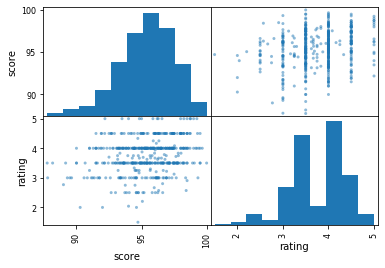

In [15]:
## YOUR CODE HERE
fig = scatter_matrix(new_inspection_df)

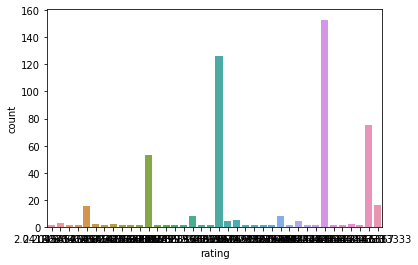

In [17]:
import seaborn as sns

sns.countplot(x="rating",data=new_inspection_df)
f1 = plt.gcf()

# Data Analysis & Result

To check the distribution, first we need to run some statistical tests on our data.

In [23]:
h_rat = new_inspection_df['rating'].values
h_sco = new_inspection_df['score'].values

array([ 96.61818182,  93.79591837,  96.31395349,  96.125     ,
        95.04285714,  96.04545455,  95.41666667,  96.03448276,
        94.55769231,  96.92307692,  95.06521739,  97.75      ,
        93.23809524,  94.5952381 ,  94.80952381,  95.975     ,
        96.52631579,  94.81578947,  96.31578947,  93.34210526,
        94.28947368,  93.42105263,  97.17647059,  93.91176471,
        95.65625   ,  94.5       ,  94.4375    ,  93.75      ,
        93.15625   ,  94.65625   ,  94.56666667,  96.23333333,
        98.03333333,  96.26666667,  96.9       ,  93.2       ,
        97.53333333,  95.19230769,  96.65384615,  95.03846154,
        96.91666667,  96.25      ,  97.16666667,  93.625     ,
        95.25      ,  96.5       ,  94.40909091,  95.81818182,
        96.68181818,  97.81818182,  96.31818182,  96.13636364,
        95.68181818,  95.04545455,  94.27272727,  96.04545455,
        94.9       ,  95.5       ,  97.65      ,  93.85      ,
        93.15      ,  95.45      ,  95.1       ,  98.2 

#### Normal test

In [36]:
st_rat = normaltest(h_rat)[0]
p_rat = normaltest(h_rat)[1]
st_sco = normaltest(h_sco)[0]
p_sco = normaltest(h_sco)[1]

This plots a histogram, withthe hypothetical normal distribution

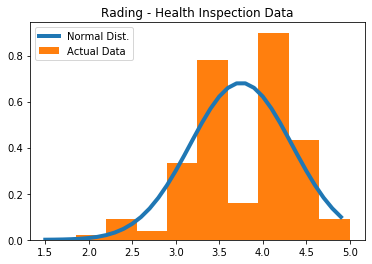

In [40]:
xs = np.arange(h_rat.min(),h_rat.max(),0.1)
fit = stats.norm.pdf(xs,np.mean(h_rat),np.std(h_rat))

plt.plot(xs, fit, label = 'Normal Dist.', lw = 4)
plt.hist(h_rat, density = True, label = 'Actual Data');
plt.title('Rading - Health Inspection Data')
plt.legend();

### Data Analysis

First, we calculate the averge score and their yelp rating

In [46]:
avg_rat = sum(h_rat)/len(h_rat)
avg_sco = sum(h_sco)/len(h_sco)

print('average rate of restaurants is ', avg_rat)
print('average health inspectino score of restaurants is ', avg_sco)

average rate of restaurants is  3.7505564238563527
average health inspectino score of restaurants is  95.40119811913594


In [58]:
pv = pd.pivot_table(new_inspection_df,values=['score'],index=['rating'])

pv

,score
rating,
1.500000,94.722222
2.000000,92.298942
2.041667,94.000000
2.204545,95.065217
2.500000,94.735316
2.571429,97.371262
2.666667,95.975000
2.750000,94.125000
2.769231,89.000000


In [63]:
outcome_1,predictors_1 = patsy.dmatrices('rating~score',new_inspection_df)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

In [64]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     29.82
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           7.49e-08
Time:                        05:04:11   Log-Likelihood:                -426.25
No. Observations:                 499   AIC:                             856.5
Df Residuals:                     497   BIC:                             864.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3847      1.124     -2.122      0.0

# Ethics & Privacy

I don't know how professor found the data of health inspection score, but I believe she found in public health website which is open source. On the other hand, I am not sure that we can use yelp rating because yelp rating is one of information from yelp, but I believe we can use it because they open it to public. 

# Conclusion & Discussion

We try to figure out the relationsihp between health inspection score and yelp rating. I formulate a hypothesis that My hypothesis is high-rating restaurants get higher food safety grade than low-rating restaurants, and I proved there is high correlation between health inspetion score and yelp rating.